In [1]:
import numpy as np
import pandas as pd
from scipy.stats import kstest,ttest_ind
import itertools as it
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 7, 'ytick.major.width': 1.5, 'ytick.major.size': 7})

In [2]:
def create_boxplot(
        box_df, xval="num_combo", yval="bmi", 
        palette=["#eecc16", "#c1272d"], 
        order=[1,2], hue_order=[1,2], figsize=(8, 6)
        ):

    # Define Canvas
    fig,ax = plt.subplots(1, 1, figsize=figsize)

    # Box Plot
    sns_strip = sns.stripplot(
        data=box_df,
        palette=palette,  # '#D1245D', '#00ADEE', '#D1245D', '#00ADEE' "#0000a7"
        x=xval,
        y=yval,
        order=order,
        orient="v",
        s=4,
        alpha=0.15, ec='black', linewidth=1, jitter=True, facecolors="none", dodge=False, ax=ax 
        )

    sns_box = sns.boxplot(
        data=box_df,
        palette=palette,  # '#D1245D', '#00ADEE', '#D1245D', '#00ADEE' "#0000a7"
        x=xval,
        y=yval,
        order=order,
        hue_order=order,
        dodge=False, width=0.25, linewidth=4, fliersize=0.5)
    
    ax.set_xlabel("")

    # Remove Spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False);
    return fig,ax

In [3]:
combinations_files = [
    "/data5/deepro/ukbiobank/papers/bmi_project/3_run_rarecomb/white_british/data/parsed_tables/combo_2.csv",
    "/data5/deepro/ukbiobank/papers/bmi_project/3_run_rarecomb/white_british/data/parsed_tables/combo_3.csv"
    ]
phenotypes_file = "/data5/deepro/ukbiobank/papers/bmi_project/2_prepare_data_for_analysis/white_british/data/samples_with_residuals.csv"
wes_file = "/data5/deepro/ukbiobank/papers/bmi_project/2_prepare_data_for_analysis/white_british/data/tables/wes.tsv"

# Compare BMI of obese individuals with a single and multiple combinations

In [4]:
def get_merged_combo_file(combo_files):
    combo_dfs = [pd.read_csv(cf) for cf in combo_files]
    combo_df = pd.concat(combo_dfs)
    return combo_df

In [5]:
combo_df = get_merged_combo_file(combinations_files)
combo_df.Case_Samples = combo_df.Case_Samples.str.split(",")
combo_df = combo_df.explode("Case_Samples").loc[:, ["unique_combo_id", "Case_Samples"]]
combo_df = combo_df.groupby("Case_Samples").agg(lambda x: "|".join(x)).reset_index()
combo_df["num_combo"] = combo_df.unique_combo_id.apply(lambda x: len(x.split("|")))


In [6]:
phenotypes_df = pd.read_csv(phenotypes_file, low_memory=False, usecols=["eid", "bmi"], dtype={"eid": str, "bmi": np.float64})
ncombo_df = combo_df.merge(phenotypes_df, left_on="Case_Samples", right_on="eid")


(<Figure size 576x432 with 1 Axes>, <AxesSubplot:ylabel='bmi'>)

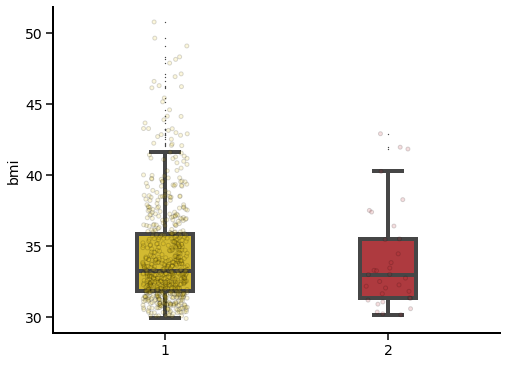

In [7]:
create_boxplot(ncombo_df)

In [8]:
for test_vars in list(it.combinations(ncombo_df.num_combo.unique(), 2)):
    bmi_g1 = ncombo_df.loc[ncombo_df.num_combo==test_vars[0], "bmi"]
    bmi_g2 = ncombo_df.loc[ncombo_df.num_combo==test_vars[1], "bmi"]
    print(f"Testing {test_vars[0]} vs {test_vars[1]}")
    print(ttest_ind(bmi_g1, bmi_g2))
    print(kstest(bmi_g1, bmi_g2))

Testing 1 vs 2
Ttest_indResult(statistic=0.47631008586036633, pvalue=0.634006258910232)
KstestResult(statistic=0.12041958041958042, pvalue=0.7057157601849868)


# Compare BMI of all individuals with a single and multiple combinations

In [9]:
def get_all_samples_with_combos(combo_df, wes_df):
    combo_2_sample_dict = dict()
    for uci in combo_df.unique_combo_id:
        genes = uci.split("_")
        cond = "(" + " & ".join([f"({c} == 1)" for c in genes]) + ")"
        combo_wes = wes_df.loc[wes_df.eval(cond)]
        combo_samples = set([str(i) for i in list(combo_wes.index)])
        combo_2_sample_dict[uci] = combo_samples
    return combo_2_sample_dict

In [10]:
combo_df = get_merged_combo_file(combinations_files)
gene_cols = sum(list(map(lambda x: x.split("_"), combo_df.unique_combo_id.values)), [])
input_cols = ["Sample_Name"] + [f"Input_{gc}" for gc in gene_cols]
wes_df = pd.read_csv(wes_file, sep="\t", low_memory=False, usecols=input_cols, index_col="Sample_Name")
wes_df.columns = [c.replace("Input_", "") for c in wes_df.columns]

In [11]:
combo_samples_dict = get_all_samples_with_combos(combo_df, wes_df)

In [12]:
data_dict = {"combo":[], "sample":[]}

for k,v in combo_samples_dict.items():
    for sample in v:
        data_dict["sample"].append(sample)
        data_dict["combo"].append(k)

In [13]:
combo_samples_df = pd.DataFrame(data_dict)
combo_samples_df = combo_samples_df.groupby("sample").agg(lambda x: "|".join(x)).reset_index()
combo_samples_df["num_combo"] = combo_samples_df.combo.apply(lambda x: len(x.split("|")))

In [14]:
ncombo_df = combo_samples_df.merge(phenotypes_df, left_on="sample", right_on="eid")

In [15]:
for test_vars in list(it.combinations(ncombo_df.num_combo.unique(), 2)):
    bmi_g1 = ncombo_df.loc[ncombo_df.num_combo==test_vars[0], "bmi"]
    bmi_g2 = ncombo_df.loc[ncombo_df.num_combo==test_vars[1], "bmi"]
    print(f"Testing {test_vars[0]} vs {test_vars[1]}")
    print(ttest_ind(bmi_g1, bmi_g2))
    print(kstest(bmi_g1, bmi_g2))

Testing 1 vs 2
Ttest_indResult(statistic=-1.7998482035614356, pvalue=0.0721543652751261)
KstestResult(statistic=0.24247247645576336, pvalue=0.014076352002817316)


(<Figure size 576x432 with 1 Axes>, <AxesSubplot:ylabel='bmi'>)

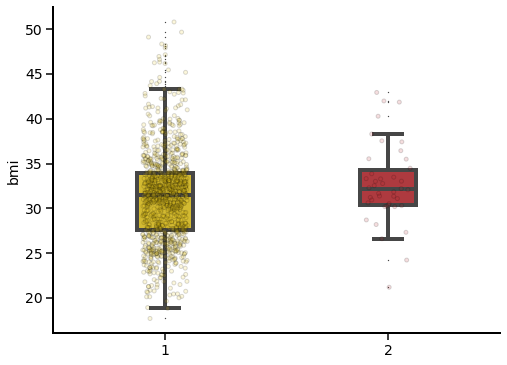

In [16]:
create_boxplot(ncombo_df)